## Training process for ECD507 Senior Capstone Project - F1Tenth ML Based Autonomous Race Car
### Contributors - Charles Hodgins, Rishabh Hegde, Dylan DiGiacomo, and Andrew Meccariello

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import ast

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


In [3]:
class DrivingDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx,1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200, 66))  # Resize using OpenCV
        image = image / 255.0  # Normalize pixel values to [0,1]
        image = np.transpose(image, (2, 0, 1))  # Change shape to (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        steering_angle = float(self.data.iloc[idx, 3])
        throttle = float(self.data.iloc[idx, 4])
        lidar = torch.tensor(ast.literal_eval(self.data.iloc[idx, 2]))
               
        return image, lidar, torch.tensor([steering_angle, throttle], dtype=torch.float32)


### Check dataset size before filtering

### Filter out unusable rows from driving dataset

In [ ]:
def filter_chunk(df):
    global first_chunk
    print(first_chunk)
    print(f"Initial size: {len(df)}")

    def is_valid_image(img_path):
        return os.path.exists(img_path) and cv2.imread(img_path) is not None
    
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    before_throttle = len(df)
    df = df[df["throttle"] != 0 ]
    # print(f"Filtered throttle: {before_throttle - len(df)} rows removed")

    before_lidar = len(df)
    df = df[df["lidar_list"] != ""]
    df = df[pd.notna(df["lidar_list"])]
    # print(f"Filtered lidar: {before_lidar - len(df)} rows removed")

    before_images = len(df)
    df["image_path"] = df["image_path"].str.strip()
    df = df[df["image_path"] != ""]
    df_filtered = df[df["image_path"].apply(is_valid_image)]
    # print(f"Filtered images: {before_images - len(df_filtered)} rows removed")

    # print(f"Final size: {len(df_filtered)}")
    
    print(len(df_filtered))
    
    if first_chunk:
        df_filtered.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv", mode='w', index=False, header=True)
        first_chunk = False
    else:
        df_filtered.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv", mode='a', index=False, header=False)


    # Save the cleaned dataset


    
first_chunk = True
index = 0
for chunk in pd.read_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log.csv",chunksize = 10000):
    index+=1
    print(f'loaded chunk {index}')
    filter_chunk(chunk)
    # print(chunk.head())
    del chunk
    
print('done')

In [15]:

dataset = DrivingDataset('/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv')
print(len(dataset))
batch_size = 16


124172


In [16]:
# Define CNN model
class CameraCNNModel(nn.Module):
    def __init__(self):
        super(CameraCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3840, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2)  # Output: Steering angle and Throttle
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

import torch.nn.functional as F


class ResNet15(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,64,kernel_size = 7, stride = 1, padding = 'same')
        self.conv1_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_bn = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv3_bn = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv4_bn = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv6_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv6_bn = nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv7_bn = nn.BatchNorm2d(128)
        self.conv7_shortcut = nn.Conv2d(64,128, kernel_size = 2, stride = 2)
        self.conv7_shortcut_bn = nn.BatchNorm2d(128)

        self.conv8 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv8_bn = nn.BatchNorm2d(128)

        self.conv9 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv9_bn = nn.BatchNorm2d(128)

        self.conv10 = nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv10_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv10_bn = nn.BatchNorm2d(256)

        self.conv11 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv11_bn = nn.BatchNorm2d(256)
        self.conv11_shortcut = nn.Conv2d(128,256, kernel_size = 2, stride = 2)
        self.conv11_shortcut_bn = nn.BatchNorm2d(256)

        self.conv12 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv12_bn = nn.BatchNorm2d(256)

        self.conv13 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv13_bn = nn.BatchNorm2d(256)

        self.conv14 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv14_bn = nn.BatchNorm2d(256)

        self.FC1 = nn.Linear(256*4*12,2)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv1_maxpool(x)
        x = F.relu(self.conv1_bn(nn.MaxPool2d(kernel_size=3,stride = 2,padding = 1)(x)))

        # first block
        x1 = F.relu(self.conv2_bn(self.conv2(x)))
        x1 = F.relu(self.conv3_bn(self.conv3(x1)))
        x = x1 + x 
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x = x1 + x

        #second block
        x2 = F.relu(self.conv6_bn(self.conv6_maxpool(self.conv6(x))))
        x2 = F.relu(self.conv7_bn(self.conv7(x2)))
        # print(x2.shape)
        # print(self.conv7_shortcut_bn(self.conv7_shortcut(x)).shape)
        x = F.relu(x2 + self.conv7_shortcut_bn(self.conv7_shortcut(x)))
        x2 = F.relu(self.conv8_bn(self.conv8(x)))
        x2 = F.relu(self.conv9_bn(self.conv9(x2)))
        x = x2 + x

        x3 = F.relu(self.conv10_bn(self.conv10_maxpool(self.conv10(x))))
        x3 = F.relu(self.conv11_bn(self.conv11(x3)))
        x = F.relu(self.conv11_shortcut_bn(self.conv11_shortcut(x)))
        x3 = F.relu(self.conv12_bn(self.conv12(x3)))
        x3 = F.relu(self.conv13_bn(self.conv13(x3)))
        x3 = F.relu(self.conv14_bn(self.conv14(x3)))
        # print(x.shape)
        x = x + x3
        

        x = x.view(x.size(0),-1)
        x = self.FC1(x)
        return x


In [ ]:
# Initialize model, loss, and optimizer
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to cuda when it begins to work
torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
print(device)
model = ResNet15().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, )

print(len(dataset)/16)
# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    batch = 0
    for images,_,targets in dataloader:
        images, targets = images.to(device,non_blocking=True), targets.to(device,non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f'batch {batch}',end = '\r')
        batch+=1
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}')

# Save model
torch.save(model.state_dict(), '/media/ecd507/JetsonOrinNano/home/ecd507/training/model.pth')
print("Model training complete and saved as model.pth")

cuda
7760.75


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0xffff02f7e3b0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0xffff02f7e3b0>
Traceback (most recent call last):
Exception ignored in: Exception ignored in:   File "/home/ecd507/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0xffff02f7e3b0>
<function _MultiProcessingDataLoaderIter.__del__ at 0xffff02f7e3b0>
  File "/home/ecd507/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    Traceback (most recent call last):
  File "/home/ecd507/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()  File "/home/ecd507/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        
self._shutdown_

Epoch 1/10, Loss: 0.03316273846788755


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0xffff8bc14670>>
Traceback (most recent call last):
  File "/home/ecd507/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

95963
tensor([0.3213, 0.3162], device='cuda:0')
tensor([0.4597, 0.2466], device='cuda:0')
tensor(0.0120, device='cuda:0')


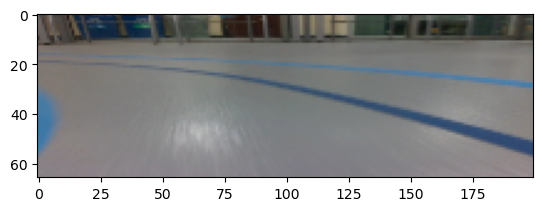

In [ ]:
checkpoint = torch.load(os.path.expanduser('~/models/4_3_2025_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to cuda when it begins to work
model = ResNet15().to(device)
model.load_state_dict(checkpoint)
model.eval()
criterion = nn.MSELoss()
idx = int(np.random.rand()*len(dataset))
print(idx)
img,lidar, label = dataset[idx]
img = img.to(device)
label = label.to(device)
img = img.unsqueeze(0) 
img_ = img.to('cpu')
img_ = np.squeeze(img_)
img_ = np.transpose(img_, (1,2,0))  # Change shape to (C, H, W)
# img_ = cv2.cvtColor(np.array(img_), cv2.COLOR_RGB2HSV)
plt.imshow(img_)

# print(img_.shape)

with torch.no_grad():
    output = model(img)
plt.imshow(img_)

print(label)
print(output[0])
loss = criterion(output[0],label)
print(loss)
